# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from timeit import default_timer as timer
import collections
from typing import List
import pickle
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE, RFECV, GenericUnivariateSelect
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Special script to keep a jupyter notebook running while idle
# Source: https://github.com/udacity/workspaces-student-support/tree/master/jupyter
# To stop this cell and proceed with working with the notebook Interrupt the kernel
# import workspace_utils
# import time
# for i in workspace_utils.keep_awake(range(2 ** 32)):
#     time.sleep(120)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Let's start be defining some functions to serialize/deserialize objects so we can
# make backups and quickly restore results
def save_df(df, path):
    """Serialize a DF to file. Used to backup progress and state of a dataframe for quick restoration
    
    PARAMS:
    df: pd.DataFrame - DF to serialize
    path: str - filename where to serialize the DF
    """
    df.to_pickle(path, protocol=4)

def load_df(path):
    """Deserialize a DF from file. Used to restore DF state
    
    PARAMS:
    path: str - path to the serialized DF file
    
    RETURNS:
    pd.DataFrame - the deserialized dataframe
    """
    return pd.read_pickle(path)

def serialize(obj, path):
    """Serialize any object to a pickle
    
    PARAMS: path - filenamew here to serialze the object
    """
    pickle.dump(obj, open(path,'wb'), protocol=4)

def deserialize(path):
    """Deserialize a pickle to object

    PARAMS:
    path: str - path to a serialized object
    
    RETURNS:
    Object - the deserialized object
    """
    return pickle.load(open(path, 'rb'))

In [3]:
# Load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [7]:
# Checkpoint
azdias = pd.read_csv('azdias.csv', low_memory=False, index_col=0)
customers = pd.read_csv('customers.csv', low_memory=False, index_col=0)

In [8]:
# Example how to save current progress with working with the dataframes
# save_df(azdias, 'azdias.pkl')
# save_df(customers, 'customers.pkl')

# Example how to restore dataframes from backup
# azdias = load_df('azdias.pkl')
# customers = load_df('customers.pkl')

In [9]:
# Look at the dimensions to verify they match the expectations
print('AZIDAS dataframe size:', azdias.shape) # general population
print('Customers dataframe size:', customers.shape) # customers of mail-order company

AZIDAS dataframe size: (891221, 366)
Customers dataframe size: (191652, 369)


We are looking at two datasets. A general population set with 890k entries and customers set with 190k entries.
Next let's look at what the data looks like:

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [12]:
count_nans_azdias = azdias.isna().sum().sum() / (azdias.shape[0] * azdias.shape[1])
count_nans_customers = customers.isna().sum().sum() / (customers.shape[0] * customers.shape[1])
print('NaNs in AZDIAS: {:.2%}'.format(count_nans_azdias))
print('NaNs in customers: {:.2%}'.format(count_nans_customers))
print('Common columns between AZDIAS and customers: ', len(set(customers.columns).intersection(azdias.columns)))
print('Additional columns in customers:', set(customers.columns).difference(azdias.columns))

NaNs in AZDIAS: 10.27%
NaNs in customers: 19.60%
Common columns between AZDIAS and customers:  366
Additional columns in customers: {'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'}


There's 10% missing values in AZDIAS and 20% missing values in customers. We will have to handle those missing values before working with the data.

In [36]:
collections.Counter(customers.dtypes)

Counter({dtype('int64'): 94, dtype('float64'): 267, dtype('O'): 8})

Of the 369 columns only 8 show as categorical, but in reality some of the int64 columns are also categorical. For example the values of AGER_TYP translate to categories as follows: (Taken from DIAS Attributes - Values 2017)
* -1: unknown
* 0: no classification possible
* 1: passive elderly
* 2: cultural elderly
* 3: experience-driven elderly

Next, we'll create some functions to help us parse these categorical features and give us explanation of what each feature signifies. To do so we can use the explanation xls files provided. To use the data however we need to import it in Python so I exported the spreadsheets from Excel to CSV and below are the functions parsing these CSV files.

In [46]:
def generate_value_substitution_dictionary(attribute_info_path='attribute_info.csv'):
    """Parse a CVS with the information about all attributes to dictionary
    The CSV is directly exported from the provided xls file
    
    PARAMS:
    attribute_info_path: str - path to the CSV with the attribute information
    
    RETURNS:
    attribute_values: dict - the keys are the parameter names and the value is dict {key: value-in-the-df, value: meaning}
    """
    class Attribute:
        def __init__(self, name, description):
            self.name = name
            self.description = description
            self.values = {}

    attr_info = pd.read_csv(attribute_info_path)
    attr_info.columns = ['empty', 'attribute', 'description', 'value', 'meaning']
    attr_info.drop('empty', axis=1, inplace=True) # Drop the first column, which is empty
    attr_info.drop(0, axis=0, inplace=True) # Remove 0th row, which is the column names
    
    # Data points with these names are marked as unknown/invalid, hence will be converted to NaNs
    unknown = set(['unknown', 'no transactions known', 'no transaction known', 'no classification possible', 'unknown / no main age detectable'])
    
    attributes_list = []
    for row in attr_info.iterrows():
        data = row[1]
        # Create new attribute
        if data['attribute'] is not np.nan:
            attributes_list.append(Attribute(data['attribute'], data['description']))
        
        if isinstance(data['meaning'], str) and data['meaning'].startswith('numeric value'): # Numeric Attribute
            attributes_list.pop() # Ignore numeric attributes, they don't need encoding
            continue
        elif data['meaning'] in unknown: # Meaning, converted to NaN
            data['meaning'] = np.nan
        
        # For each possible value map its corresponding meaning
        vals = data['value'].split(',')
        for i in range(len(vals)):
            try:
                vals[i] = int(vals[i]) # Convert value to number if possible
            except:
                pass # If value is string - keept it as is
            attributes_list[-1].values[vals[i]] = data['meaning'] 

    # Convert attributes to dictionary {feature: {val: meaning}}
    attribute_values = {}
    for attr in attributes_list:
        attribute_values[attr.name] = attr.values
    
    return attribute_values

In [47]:
def generate_value_meaning_dictionary(attribute_info_path='attribute_info.csv'):
    """Parse a CVS with the information about all attributes to dictionary
    The CSV is directly exported from the provided xls file
    
    PARAMS:
    attribute_info_path: str - path to the CSV with the attribute information
    
    RETURNS:
    attribute_values: dict - the keys are the parameter names and the value is the meaning
    """
    attr_info = pd.read_csv(attribute_info_path)
    attr_info.columns = ['empty', 'attribute', 'description', 'value', 'meaning']
    attr_info.drop('empty', axis=1, inplace=True) # Drop the first column, which is empty
    attr_info.drop(0, axis=0, inplace=True) # Remove 0th row, which is the column names
    
    attribute_meaning = {}
    for row in attr_info.iterrows():
        data = row[1]
        # Create new attribute
        if data['attribute'] is not np.nan:
            attribute_meaning[data['attribute']] = data['description']
    
    return attribute_meaning

In [48]:
# Instantiate a map with {value: meaning} entries
attribute_meaning = generate_value_meaning_dictionary()

In [49]:
def explain_column(column, attribute_meaning=attribute_meaning):
    """Explain a column meaning based on the provided xls explanation file
    
    PARAMS:
    column: str - the column to explain
    attribute_meaning: dict - the dictionary from which to pull the meaning
    
    RETURNS:
    str - the meaning of the attribute
    """
    try:
        return attribute_meaning[column]
    except:
        return ''

In [50]:
# Instantiate a map with {feature: {value: meaning}}
attr_map = generate_value_substitution_dictionary()

In [51]:
# Example what an entry in the attribute map looks like
attr_map['AGER_TYP']

{-1: nan,
 0: nan,
 1: 'passive elderly',
 2: 'cultural elderly',
 3: 'experience-driven elderly'}

In [52]:
# Example usage of the explanation function
explain_column('AGER_TYP')

'best-ager typology'

Let's write a function to use this Feature map we just created and apply it to the dataframes we have.

In [53]:
def map_df(df, attr_map=attr_map):
    """Map columns from a dataframe according to a given attribute map
    
    PARAMS:
    df: pd.DataFrame - dataframe to map columns on
    attr_map: dict - a map with feature maps {feature: {value: meaning}}

    RETURNS:
    mapped: pd.DataFrame - a copy of the original dataframe with columns mapped where possible
    """
    mapped = pd.DataFrame()
    for col in df.columns:
        if col in attr_map:
            mapped[col] = df[col].map(attr_map[col])
        else:
            mapped[col] = df[col].copy()
    return mapped

In [45]:
azdias = map_df(azdias)
customers = map_df(customers)

In [47]:
# Checkpoint
# save_df(customers, 'customers_1.pkl')
# save_df(azdias, 'azdias_1.pkl')
# customers = load_df('customers_1.pkl')
# azdias = load_df('azdias_1.pkl')

In [49]:
# Let's check how the NaNs have changed after the mapping
count_nans_azdias = azdias.isna().sum().sum() / (azdias.shape[0] * azdias.shape[1])
count_nans_customers = customers.isna().sum().sum() / (customers.shape[0] * customers.shape[1])
print('NaNs in mapped AZDIAS: {:.2%}'.format(count_nans_azdias))
print('NaNs in mapped customers: {:.2%}'.format(count_nans_customers))

NaNs in mapped AZDIAS: 16.48%
NaNs in mapped customers: 25.55%


We have had an increase of about 5% in the numbers of NaNs in both dataframes, which is not too bad. But let's look at the missing features in more detail to determine the general state of the dataframes and try to find any features we can possibly drop.

In [56]:
azdias_nans = azdias.isna().sum() / azdias.shape[0] * 100

Text(0, 0.5, 'Number of features')

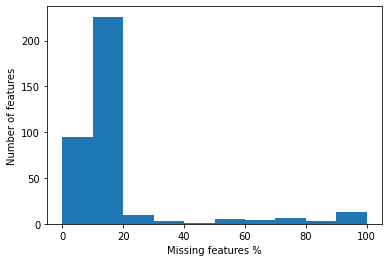

In [57]:
plt.hist(azdias_nans);
plt.xlabel('Missing features %');
plt.ylabel('Number of features')

Seems like most features have less than 20% missing values. There's few features with missing 30%/40% entries and then there is a second group of features with more than 40% missing values. Let's look at the raw numbers of the missing values.

In [58]:
azdias_nans.sort_values(ascending=False).head(20)

CAMEO_DEUG_2015             100.000000
ALTER_KIND4                  99.864792
TITEL_KZ                     99.757636
ALTER_KIND3                  99.307691
D19_TELKO_ONLINE_DATUM       99.079577
D19_BANKEN_OFFLINE_DATUM     97.791120
ALTER_KIND2                  96.690047
D19_TELKO_ANZ_12             96.271295
D19_BANKEN_ANZ_12            93.325225
D19_TELKO_ANZ_24             92.705176
D19_VERSI_ANZ_12             92.153237
D19_TELKO_OFFLINE_DATUM      91.909190
ALTER_KIND1                  90.904837
D19_BANKEN_ANZ_24            89.102479
D19_VERSI_ANZ_24             87.187914
D19_BANKEN_ONLINE_DATUM      81.571462
AGER_TYP                     76.955435
D19_BANKEN_DATUM             76.112547
D19_TELKO_DATUM              74.706274
EXTSEL992                    73.399639
dtype: float64

In [59]:
azdias_nans = azdias_nans.sort_values()
azdias_nans.sort_values(ascending=True).head(67)

LNR                  0.000000
SEMIO_KULT           0.000000
D19_HAUS_DEKO        0.000000
SEMIO_KRIT           0.000000
SEMIO_FAM            0.000000
                       ...   
D19_KOSMETIK         0.000000
D19_LEBENSMITTEL     0.000000
FINANZ_HAUSBAUER     0.000000
CJT_KATALOGNUTZER    0.544646
RT_KEIN_ANREIZ       0.544646
Length: 67, dtype: float64

In [ ]:
# List all the features with less than 40% missing values
for x in sorted(azdias_nans[azdias_nans <= 40].index):
    print(x)

We will be focusing on the features with less than 40% missing values going forward with this notebook. And will drop the features with more than 40% missing values.
The fields with less than 40% missing values seem to be mainly from the following categories:
- D19: connected with the banking habits of the people.
- KBA05: connected with car ownership
- KBA13: connected with car ownership
- Others

In [62]:
columns_to_drop = sorted(azdias_nans[azdias_nans > 40].index)
columns_to_drop

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEUG_2015',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'LP_STATUS_GROB',
 'TITEL_KZ']

In [54]:
def drop_columns(df, drop_columns=None) -> pd.DataFrame:
    """Drop columns from a DataFrame
    
    PARAMS:
    df: pd.DataFrame - dataframe to operate on
    drop_columns: List - columns to drop

    RETURNS:
    pd.DataFrame - the dataframe with dropped columns
    """
    # Drop specific columns by name
    if not drop_columns:
        drop_columns = ['AGER_TYP','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','CAMEO_DEUG_2015',
                        'D19_BANKEN_ANZ_12','D19_BANKEN_ANZ_24','D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM',
                        'D19_BANKEN_ONLINE_DATUM','D19_GESAMT_ANZ_12','D19_GESAMT_ANZ_24','D19_GESAMT_OFFLINE_DATUM',
                        'D19_GESAMT_ONLINE_DATUM','D19_TELKO_ANZ_12','D19_TELKO_ANZ_24','D19_TELKO_DATUM',
                        'D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM','D19_VERSAND_ANZ_12','D19_VERSAND_ANZ_24',
                        'D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM','D19_VERSI_ANZ_12',
                        'D19_VERSI_ANZ_24','EXTSEL992','KBA05_BAUMAX','KK_KUNDENTYP','LP_STATUS_GROB','TITEL_KZ']
    df.drop(drop_columns, axis=1, inplace=True)
    
    return df

In [65]:
customers = drop_columns(customers, drop_columns=columns_to_drop + ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'])
azdias = drop_columns(azdias, drop_columns=columns_to_drop)

In [14]:
# Checkpoint
# save_df(customers, 'customers_2.pkl')
# save_df(azdias, 'azdias_2.pkl')
# customers = load_df('customers_2.pkl')
# azdias = load_df('azdias_2.pkl')

In [15]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fair supplied,male,30 - 45 years
1,910220,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,likely,length of residence more than 10 years,poor neighbourhood,seeking orientation,female,< 30 years
2,910225,9.0,01.01.1975 bis 31.12.1979,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,likely,length of residence more than 10 years,good neighbourhood,seeking orientation,female,46 - 60 years
3,910226,1.0,01.01.1955 bis 31.12.1959,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,length of residence more than 10 years,rural neighbourhood,fair supplied,female,> 60 years
4,910241,1.0,01.01.1990 bis 31.12.1994,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,very likely,length of residence more than 10 years,average neighbourhood,price driven,male,46 - 60 years


In [16]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,01.01.1940 bis 31.12.1944,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,3.0,5.0,3.0,2.0,very unlikely,length of residence more than 10 years,rural neighbourhood,fair supplied,male,> 60 years
1,9628,9.0,01.01.1945 bis 31.12.1949,NaN,NaN,NaN,0.0,3.0,NaN,0.0,...,NaN,6.0,6.0,3.0,NaN,length of residence more than 10 years,NaN,fair supplied,male,> 60 years
2,143872,1.0,01.01.1920 bis 31.12.1924,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,4.0,10.0,13.0,11.0,very unlikely,length of residence more than 10 years,good neighbourhood,fair supplied,female,> 60 years
3,143873,1.0,01.01.1930 bis 31.12.1934,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,6.0,4.0,2.0,NaN,length of residence more than 10 years,rural neighbourhood,green,male,> 60 years
4,143874,1.0,01.01.1990 bis 31.12.1994,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,4.0,3.0,5.0,4.0,very likely,length of residence more than 10 years,average neighbourhood,green,male,46 - 60 years


We looked at columns with missing values. Next let's look at rows with missing values.

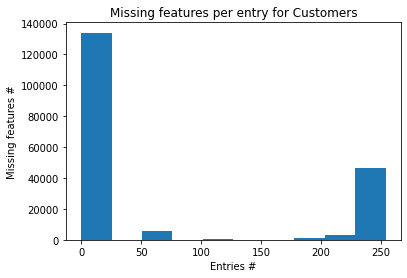

In [17]:
customers_rows_nan = customers.isna().sum(axis = 1)
plt.hist(customers_rows_nan);
plt.title('Missing features per entry for Customers');
plt.xlabel('Entries #');
plt.ylabel('Missing features #');

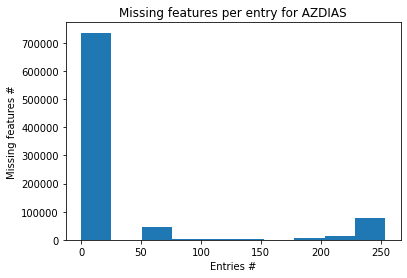

In [18]:
azdias_rows_nan = azdias.isna().sum(axis = 1)
plt.hist(azdias_rows_nan);
plt.title('Missing features per entry for AZDIAS');
plt.xlabel('Entries #');
plt.ylabel('Missing features #');

In [19]:
# The graphics are a good visualization but don't tell us much in terms of exact numbers
# We will drop the top 5% rows with most missing values
customers_rows_nan.quantile(.95), azdias_rows_nan.quantile(.95)

(254.0, 254.0)

In [20]:
customers_rows_to_drop = customers_rows_nan[customers_rows_nan >= 254].index
azdias_rows_to_drop = azdias_rows_nan[azdias_rows_nan >= 254].index

In [21]:
len(customers_rows_to_drop), len(azdias_rows_to_drop)

(40967, 45580)

In [22]:
customers.drop(customers_rows_to_drop, inplace=True)
azdias.drop(azdias_rows_to_drop, inplace=True)

In [23]:
# Checkpoint
# save_df(customers, 'customers_3.pkl')
# save_df(azdias, 'azdias_3.pkl')
# customers = load_df('customers_3.pkl')
# azdias = load_df('azdias_3.pkl')

In [55]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
    """Impute all categorical values with the mode and all numerical with the mean

    PARAMS:
    df: pd.DataFrame - dataframe to impute values for

    RETURNS:
    df: pd.DataFrame - the input dataframe with imputed values inplace
    """
    for column in df.columns:
        if df[column].isna().sum() == 0:
            continue
        if df[column].dtype == 'O': # Categorical
            replacer = df[column].value_counts().sort_values(ascending=False).index[0]
        else: # Numerical
            replacer = df[column].mean()
        df[column].fillna(replacer, inplace=True)
    return df

In [25]:
customers = impute(customers)

In [26]:
azdias = impute(azdias)

In [28]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,01.01.1940 bis 31.12.1944,10.000000,1.000000,0.000000,0.0,2.0,1.000000,0.0,...,3.000000,5.0,3.0,2.0,very unlikely,length of residence more than 10 years,rural neighbourhood,fair supplied,male,> 60 years
1,9628,9.0,01.01.1945 bis 31.12.1949,10.331579,4.965863,0.067413,0.0,3.0,4.701288,0.0,...,2.429508,6.0,6.0,3.0,very unlikely,length of residence more than 10 years,average neighbourhood,fair supplied,male,> 60 years
2,143872,1.0,01.01.1920 bis 31.12.1924,0.000000,1.000000,0.000000,0.0,1.0,1.000000,0.0,...,4.000000,10.0,13.0,11.0,very unlikely,length of residence more than 10 years,good neighbourhood,fair supplied,female,> 60 years
3,143873,1.0,01.01.1930 bis 31.12.1934,8.000000,0.000000,0.067413,0.0,0.0,1.000000,0.0,...,2.000000,6.0,4.0,2.0,very unlikely,length of residence more than 10 years,rural neighbourhood,green,male,> 60 years
4,143874,1.0,01.01.1990 bis 31.12.1994,14.000000,7.000000,0.000000,0.0,4.0,7.000000,0.0,...,4.000000,3.0,5.0,4.0,very likely,length of residence more than 10 years,average neighbourhood,green,male,46 - 60 years


In [27]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,4.421937,01.01.1980 bis 31.12.1984,13.700717,8.287263,0.040647,0.154018,1.727639,7.599356,0.004162,...,2.417322,6.001214,7.53213,5.945972,very unlikely,length of residence more than 10 years,average neighbourhood,fair supplied,male,30 - 45 years
1,910220,9.000000,01.01.1980 bis 31.12.1984,21.000000,11.000000,0.000000,0.000000,2.000000,12.000000,0.000000,...,4.000000,8.000000,11.00000,10.000000,likely,length of residence more than 10 years,poor neighbourhood,seeking orientation,female,< 30 years
2,910225,9.000000,01.01.1975 bis 31.12.1979,17.000000,10.000000,0.000000,0.000000,1.000000,7.000000,0.000000,...,2.000000,9.000000,9.00000,6.000000,likely,length of residence more than 10 years,good neighbourhood,seeking orientation,female,46 - 60 years
3,910226,1.000000,01.01.1955 bis 31.12.1959,13.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,7.000000,10.00000,11.000000,very unlikely,length of residence more than 10 years,rural neighbourhood,fair supplied,female,> 60 years
4,910241,1.000000,01.01.1990 bis 31.12.1994,14.000000,3.000000,0.000000,0.000000,4.000000,3.000000,0.000000,...,2.000000,3.000000,5.00000,4.000000,very likely,length of residence more than 10 years,average neighbourhood,price driven,male,46 - 60 years


After we are done with cleaning the data we can check the status of the numerical values in the dataframes.

In [29]:
azdias.describe()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,8.456410e+05,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,...,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.000000,845641.00000,845641.000000
mean,6.365743e+05,4.421937,13.700717,8.287263,0.040647,0.154018,1.727639,7.599356,0.004162,3.167854,...,2.539212,3.223125,4.017526,0.090068,4.585760,0.438821,2.417322,6.001214,7.53213,5.945972
std,2.573449e+05,3.578229,4.378570,15.182179,0.314021,0.494026,1.136608,13.923268,0.067709,0.971291,...,0.731488,1.216404,1.083327,0.281513,8.208505,1.124259,1.113194,2.804393,3.18900,2.721297
min,1.916530e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
25%,4.134990e+05,1.000000,13.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,...,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,4.000000,6.00000,4.000000
50%,6.363050e+05,3.000000,13.700717,4.000000,0.000000,0.000000,1.000000,4.000000,0.000000,3.000000,...,3.000000,3.000000,4.000000,0.000000,1.000000,0.000000,2.417322,6.000000,8.00000,6.000000
75%,8.593830e+05,9.000000,16.000000,9.000000,0.000000,0.000000,2.000000,8.000000,0.000000,4.000000,...,3.000000,4.000000,5.000000,0.000000,4.585760,0.000000,3.000000,8.000000,10.00000,8.000000
max,1.082873e+06,9.000000,25.000000,595.000000,23.000000,11.000000,45.000000,449.000000,6.000000,9.000000,...,3.000000,5.000000,5.000000,1.000000,45.000000,5.000000,4.000000,11.000000,13.00000,11.000000


In [49]:
# Checkpoint
# save_df(customers, 'customers_4.pkl')
# save_df(azdias, 'azdias_4.pkl')
# customers = load_df('customers_4.pkl')
# azdias = load_df('azdias_4.pkl')

In [56]:
def clean_df(df, is_customer=False, drop_rows=False):
    df = map_df(df)
    df = drop_columns(df)
    if is_customer:
        df = drop_columns(df, ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'])
    if drop_rows:
        rows_nans = df.isna().sum(axis = 1)
        rows_to_drop = rows_nans[rows_nans >= 254].index
        df.drop(rows_to_drop, inplace=True)
    df = impute(df)
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [51]:
def summarize(df):
    """Find the mean for numerical values and the mode for categorical in a dataframe

    PARAMS:
    df: pd.DataFrame - dataframe to summarize

    RETURNS:
    List[(str, mean/mode value)] - a list of column name and summary for that column 
    """
    summary = []
    for column in df.columns:
        if df[column].dtype == 'O': # Categorical median
            summary.append((column, df[column].value_counts().sort_values(ascending=False).index[0]))
        else: # Numerical mean
            summary.append((column, df[column].mean()))
    return summary

In [33]:
# Taking the summary of the two dataframes we'll create a dataframe combining the results
customer_summary = summarize(customers)
azdias_summary = summarize(azdias)
summary = pd.DataFrame(azdias_summary)
summary[2] = pd.DataFrame(customer_summary)[1]
summary.index = summary[0]
summary.drop([0], axis = 1, inplace=True)
summary.index.name = None
summary.columns = ['Azdias', 'Customers']

summary = summary.transpose()
summary

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Azdias,636574,4.42194,01.01.1980 bis 31.12.1984,13.7007,8.28726,0.0406465,0.154018,1.72764,7.59936,0.00416157,...,2.41732,6.00121,7.53213,5.94597,very unlikely,length of residence more than 10 years,average neighbourhood,fair supplied,female,46 - 60 years
Customers,95957.7,1.7474,01.01.1940 bis 31.12.1944,10.3316,4.96586,0.0674134,0.136405,2.26785,4.70129,0.0203925,...,2.42951,4.37442,4.56477,3.16887,very unlikely,length of residence more than 10 years,average neighbourhood,fair supplied,male,> 60 years


Below is a list of all columns with their explanation where known.

In [56]:
column_explanations = []
for column in summary.columns:
    if explain_column(column) != '':
        column_explanations.append((column, explain_column(column)))

column_explanations[0:5]

[('ALTER_HH', 'main age within the household'),
 ('ANZ_HAUSHALTE_AKTIV', 'number of households in the building'),
 ('ANZ_HH_TITEL', 'number of academic title holder in building'),
 ('ANZ_PERSONEN', 'number of adult persons in the household'),
 ('ANZ_TITEL', 'number of professional title holder in household ')]

Here we can pick any number of columns to see how they differe between the two datasets. I've picked some, which seem interesting, but I do not have extensive knowledge on the datase because the fields are in German and I'm working with a brief description of each feature so feel free to try other features if they interest you.

In [44]:
interesting_columns_numerical = ['ANZ_HH_TITEL', 'ANZ_TITEL', 'ANZ_PERSONEN']
summary_numerical = summary[interesting_columns_numerical].transpose()
summary_numerical['Explanation'] = [ explain_column(x) for x in summary_numerical.index ]
summary_numerical

,Azdias,Customers,Explanation
ANZ_HH_TITEL,0.0406465,0.0674134,number of academic title holder in building
ANZ_TITEL,0.00416157,0.0203925,number of professional title holder in household
ANZ_PERSONEN,1.72764,2.26785,number of adult persons in the household


In [45]:
interesting_columns_categorical = ['FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_SPARER', 'FINANZTYP', 'HH_EINKOMMEN_SCORE', 'KKK', 'REGIOTYP', 'SHOPPER_TYP', 'VERS_TYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB']
summary_categorical = summary[interesting_columns_categorical].transpose()
summary_categorical['Explanation'] = [ explain_column(x) for x in summary_categorical.index ]
summary_categorical

,Azdias,Customers,Explanation
FINANZ_ANLEGER,very high,very high,financial typology: investor
FINANZ_HAUSBAUER,average,high,financial typology: main focus is the own house
FINANZ_SPARER,very high,very high,financial typology: money saver
FINANZTYP,unremarkable,Investor,best descirbing financial type for the person
HH_EINKOMMEN_SCORE,very low income,highest income,estimated household net income
KKK,average,average,purchasing power
REGIOTYP,traditional workers,traditional workers,neighbourhood
SHOPPER_TYP,Shopping-stressed,demanding shopper,shopping typology
VERS_TYP,individualistic-accepting risks,social-safety driven,insurance typology
ANREDE_KZ,female,male,gender


From the above summary we could say that Customers seem to be more educated overall. Also they have marginally more adult people in a household. And from the categorical data, while a lot of the features are very similar, there are some features, which are marginally different between the two datasets. For example the 'Finanztyp' - Customers are mainly Investors. Also Customers are mainly in the 60+ age category. The other striking difference is in the Estimated household net income, where Custoemrs have the highest income, while the general population has very low income on average.

To summarize Customers are more likely to be people who are educated, Investors, have the highest income, social-safety driven, 60+ year old people.

These are just some examples for features we can compare between the general population and customers to see who can become a potential customer.

In [46]:
numerical_features = azdias.dtypes[(azdias.dtypes == 'float64') | (azdias.dtypes == 'int64') ].index

In [47]:
# Before proceeding with other uninformed learning methods we have to scale the numerical features because
# a lot of the techniques rely on scaled data and will give wrong results otherwise
scaler = StandardScaler()
scaler.fit(np.concatenate((azdias[numerical_features].values, customers[numerical_features].values), axis=0));

azdias[numerical_features] = scaler.transform(azdias[numerical_features].values)
customers[numerical_features] = scaler.transform(customers[numerical_features].values)

In [48]:
# Checkpoint
save_df(customers, 'customers_5.pkl')
save_df(azdias, 'azdias_5.pkl')
# customers = load_df('customers_5.pkl')
# azdias = load_df('azdias_5.pkl')

In [49]:
# One way to convert categorical variables to numerical is via dummy variables
customers_dummy = pd.get_dummies(customers)
azdias_dummy = pd.get_dummies(azdias)

In [50]:
# Checkpoint
# save_df(customers_dummy, 'customers_dummy.pkl')
# save_df(azdias_dummy, 'azdias_dummy.pkl')
# customers_dummy = load_df('customers_dummy.pkl')
# azdias_dummy = load_df('azdias_dummy.pkl')

In [14]:
# Sadly this cell fails to execute because it consumes too much memory
# kmeans = KMeans(azdias_dummy, n_clusters=8)

Because we cannot use dummy variables to do clustering, let's try another method of encoding categorical variables, such as OrdinalEncoder.

In [51]:
categorical_columns = azdias.dtypes[azdias.dtypes == 'O'].index

In [52]:
# In order to use clustering methods we need to have only numerical values
# We can use OrdinalEncoder for mapping the categorical variables to numeric
# OrdinalEncoder is good in our case because it assigns some form of ranking to the data, which
# is already present in the original dataset as many features are either age groups or
# scores (e.g [low income, average income, high income])
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(pd.concat((azdias[categorical_columns], customers[categorical_columns])))
azdias[categorical_columns] = ordinal_encoder.transform(azdias[categorical_columns])
customers[categorical_columns] = ordinal_encoder.transform(customers[categorical_columns])

In [25]:
# Checkpoint
# save_df(customers, 'customers_6.pkl')
# save_df(azdias, 'azdias_6.pkl')
# customers = load_df('customers_6.pkl')
# azdias = load_df('azdias_6.pkl')

In [59]:
# We can now apply the KMeans clustering method and see if we can split the data in clusters
# in a way that we can reason about the relationship between the two datasets
for i in range(5, 20):
    clusters_means = KMeans(random_state=42, n_clusters=i).fit(azdias)
    customers_pred = clusters_means.predict(customers)
    azdias_pred = clusters_means.predict(azdias)
    print('Clusters', i, ':')
    print('azdias:   ', np.array([ x[1] for x in sorted(collections.Counter(azdias_pred).items()) ]) / len(azdias_pred))
    print('customers:', np.array([ x[1] for x in sorted(collections.Counter(customers_pred).items()) ]) / len(customers_pred))

Clusters 5 :
azdias:    [0.799312   0.01928714 0.02937298 0.11800043 0.03402744]
customers: [0.82422935 0.01546936 0.02752762 0.10242559 0.03034808]
Clusters 6 :
azdias:    [0.0332517  0.79468711 0.09474115 0.01714912 0.02450922 0.03566171]
customers: [0.02976408 0.81817699 0.08012742 0.0135249  0.02290208 0.03550453]
Clusters 7 :
azdias:    [0.7946741  0.01276428 0.02301568 0.0943651  0.03586155 0.02683645
 0.01248284]
customers: [0.81816372 0.00952981 0.02169426 0.07980887 0.03556426 0.02365199
 0.01158709]
Clusters 8 :
azdias:    [0.02046258 0.79074572 0.01370794 0.04073123 0.08490601 0.02579345
 0.0125869  0.01106616]
customers: [0.0192919  0.81604008 0.01220427 0.04028935 0.06950924 0.0228689
 0.01141454 0.00838172]
Clusters 9 :
azdias:    [0.76775842 0.0127631  0.02037862 0.06442805 0.01246155 0.01235394
 0.0542547  0.02537602 0.03022559]
customers: [0.807081   0.00952981 0.0192189  0.06019179 0.01156718 0.01119554
 0.02838371 0.02240435 0.03042771]
Clusters 10 :
azdias:    [0.76

The azdias and customers do not spread properly across clusters, but instead 80% of the values fall into one cluster. That doesn't help us in any way, because it doesn't give us any information about the relationship between the two datasets.

In [13]:
# KMeans didn't work very well so let's try KModes instead
# kmodes = KModes().fit(azdias) # runs for 10~ hours

In [20]:
# Checkpoint
# serialize(kmodes, 'kmodes.pkl')
# kmodes = deserialize('kmodes.pkl')

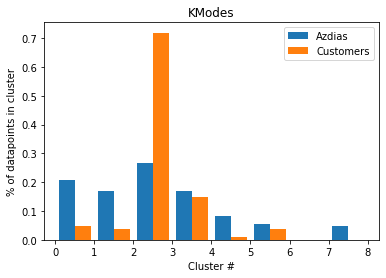

In [26]:
azdias_pred_kmodes = predict_splits(kmodes, [azdias])
customers_pred_kmodes = predict_splits(kmodes, [customers])
plot_predictions(azdias_pred_kmodes, customers_pred_kmodes, 'KModes')

In [16]:
# Here, just like with the KMeans we can see a general trend where most Customers are in cluster 2, followed by clusters 3,5,6
# We define cluster scores for the clusters resulting from KModes
kmodes_scores = [-1,-1,2,1,-1,-1,-1,-1]

# Adding the scores to each data point according to the kmodes cluster scores
azdias_scores = np.zeros(sum(x.shape[0] for x in azdias_dummy_split))
for i,x in enumerate(azdias_pred_kmodes):
    azdias_scores[i] += kmodes_scores[x]

KMeans doesn't give us any good results and KModes runs very slowly. We'll go back to using the dummy variable dataframes but using the MiniBatchKMeans cluster algorithm this time to reduce memory usage.

In [8]:
def mini_batch_kmeans_train(df_splits: List[pd.DataFrame], n_clusters=8, random_state=42):
    """Train a MiniBatchKMeans from a list of dataframes using partial_fit

    PARAMS:
    df_splits: List[pd.DataFrame] - list of dataframe parts to use for training
    n_clusters: int - number of clusters in the model
    random_state: int - random state

    RETURNS:
    kmeans: MiniBatchKMeans model
    """
    kmeans = MiniBatchKMeans(random_state=random_state, n_clusters=n_clusters)
    for index, split in enumerate(df_splits):
        kmeans.partial_fit(split)
    return kmeans

def predict_evaluate(model, df_splits: List[pd.DataFrame]):
    """Predict the values for the dataframe splits and return a report of how much of the data is in each cluster
    
    PARAMS:
    model: MiniBatchKMeans - model to use for prediction
    df_splits: List[pd.DataFrame] - list of dataframe parts to predict

    RETURNS:
    np.array - list of percentages of how many of the data points are in each cluster
    """
    results = []
    for index, split in enumerate(df_splits):
        results += list(model.predict(split))
    return np.array([ x[1] for x in sorted(Counter(results).items()) ]) / len(results)

def predict_splits(model, df_splits: List[pd.DataFrame]):
    """Predict the values for the dataframe splits
    
    PARAMS:
    model: MiniBatchKMeans - model to use for prediction
    df_splits: List[pd.DataFrame] - list of dataframe parts to predict

    RETURNS:
    List[int] - predicted clusters
    """
    results = []
    for split in df_splits:
        results += list(model.predict(split))
    return results

In [55]:
# Before we proceed with the more clustering algorithms we should fix the dummy dataframes
azdias_dummy.shape, customers_dummy.shape

((845641, 6692), (150685, 4555))

In [56]:
# Because the dummy dataframes have different columns we need to determine the extra
# columns and add them as empty features to the other dataframe or drop the extra columns
# I chose to add the extra columns as empty features to both dataframes
# First, determine the columns to add to each dataframe
customer_dummy_cols = set(customers_dummy.columns)
azdias_dummy_cols = set(azdias_dummy.columns)
intersection = customer_dummy_cols.intersection(azdias_dummy_cols)
missing_cols_in_azdias = list(customer_dummy_cols.difference(intersection))
missing_cols_in_customers = list(azdias_dummy_cols.difference(intersection))

In [57]:
# Append a column of zeroes for each missing missing column
for col in missing_cols_in_azdias:
    azdias_dummy[col] = np.zeros(azdias_dummy.shape[0])
for col in missing_cols_in_customers:
    customers_dummy[col] = np.zeros(customers_dummy.shape[0])

azdias_dummy.shape, customers_dummy.shape

((845641, 6784), (150685, 6784))

In [58]:
# Checkpoint
# save_df(customers_dummy, 'customers_dummy_2.pkl')
# save_df(azdias_dummy, 'azdias_dummy_2.pkl')
# customers_dummy = load_df('customers_dummy_2.pkl')
# azdias_dummy = load_df('azdias_dummy_2.pkl')

In [59]:
# Split the dataframes for processing in parts to save RAM
azdias_dummy_split = np.array_split(azdias_dummy, 10)
customers_dummy_split = np.array_split(customers_dummy, 10)

In [4]:
# Checkpoint
# serialize(customers_dummy_split, 'customers_dummy_split.pkl')
# serialize(azdias_dummy_split, 'azdias_dummy_split.pkl')
customers_dummy_split = deserialize('customers_dummy_split.pkl')
azdias_dummy_split = deserialize('azdias_dummy_split.pkl')

In [9]:
# In order to evaluate the clustering results we will define a function to plot
# the predictions to see how the clusters are formed side by side
def plot_predictions(azdias_pred, customers_pred, title):
    """Plot side by side bars for cluster predictions

    PARAMS:
    azdias_pred: List[int] - predictions for Azdias
    customers_pred: List[int] - predictions for Customers
    title: str - the title of the plot
    """
    max_val = max(max(azdias_pred), max(customers_pred)) + 2
    plt.xticks(range(0, max_val))
    plt.hist([azdias_pred, customers_pred], density=True, label=['Azdias', 'Customers'], bins=range(0, max_val))
    plt.legend()
    plt.title(title)
    plt.ylabel('% of datapoints in cluster')
    plt.xlabel('Cluster #')
    plt.show()

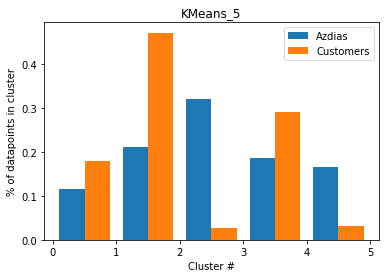

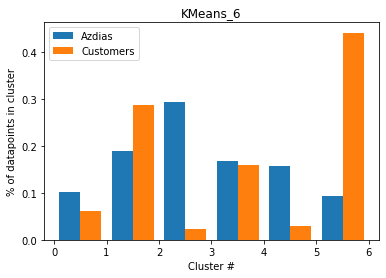

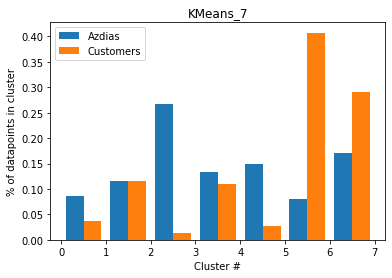

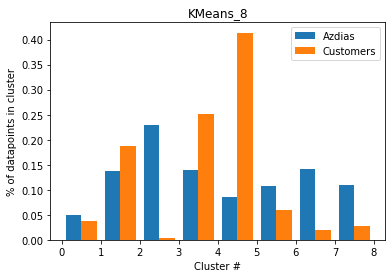

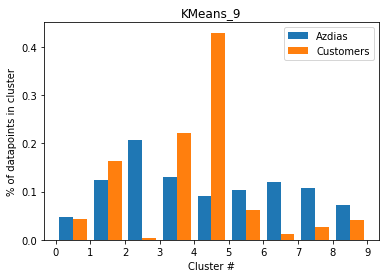

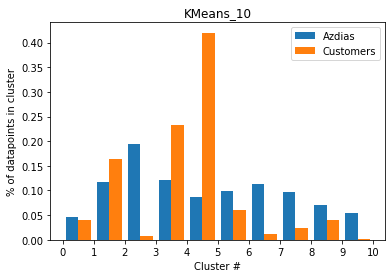

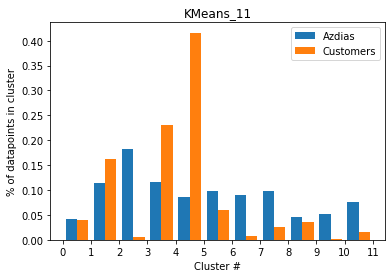

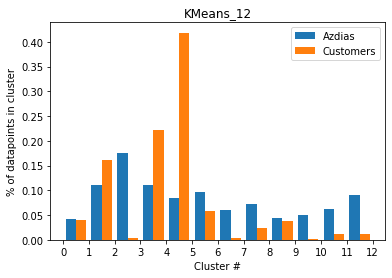

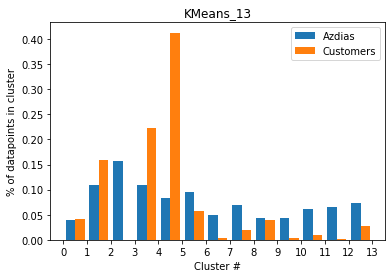

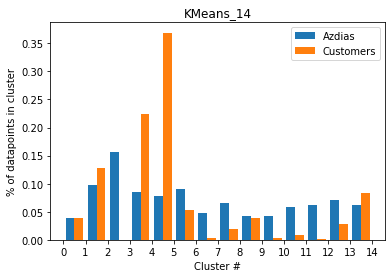

In [10]:
# We'll run the MiniBatchKMeans 10 times with clusters of different size
kmeans_list = []
for i in range(5, 15):
    kmeans = mini_batch_kmeans_train(azdias_dummy_split, n_clusters=i)
    kmeans_list.append(kmeans)
    azdias_pred = predict_splits(kmeans, azdias_dummy_split)
    customers_pred = predict_splits(kmeans, customers_dummy_split)
    plot_predictions(azdias_pred, customers_pred, 'KMeans_' + str(i))

For the first three runs (with 5,6, and 7 clusters) the customers are evenly spread and there is no general trend. However for the runs with 8-14 clusters we can see definitely a trend occurring where the Customers are mainly spread between 1/2 clusters. For example in clusters 8 and 9 50% of all customers fall into the 4th cluster.

In [12]:
# Checkpoint
# serialize(kmeans_list, 'kmeans_list.pkl')
# kmeans_list = deserialize('kmeans_list.pkl')

In [27]:
# One way to interpret the data from the clustering would be to assign each cluster a score and
# if a data point falls inside a cluster we add the cluster score to the data point.
# Cluster scores will be higher if it has a lot of customers and will be lower otherwise.
# At the end each data point will accumulate a total score based on which clusters it was in
# and we could use the highest scores to say that these data points are more likely to be customers
# because they were in the same clusters as customers.
# Below is an example how we can assign points to each cluster
cluster_score = []
cluster_score.append([0,2,-1,1,-1]) # 5 clusters
cluster_score.append([-1,1,-1,0,-1,2])# 6
cluster_score.append([-1,0,-1,0,-1,2,1]) # 7
cluster_score.append([-1,1,-1,1,2,-1,-1,-1]) # 8
cluster_score.append([-1,1,-1,1,2,0,-1,-1,-1]) # 9
cluster_score.append([-1,1,-1,1,2,0,-1,-1,-1,-1]) # 10
cluster_score.append([-1,1,-1,1,2,0,-1,-1,-1,-1,-1]) # 11
cluster_score.append([0,1,-1,1,2,0,-1,-1,0,-1,-1,-1]) # 12
cluster_score.append([0,1,-1,1,2,0,-1,-1,-1,-1,-1,-1,-1]) # 13
cluster_score.append([0,1,-1,1,2,0,-1,-1,0,-1,-1,-1,-1,0]) # 14 clusters

In [18]:
# Calculating the score for each data point in Azdias according to the above cluster scores
azdias_scores = np.zeros(sum(x.shape[0] for x in azdias_dummy_split))
for index, model in enumerate(kmeans_list):
    azdias_pred = predict_splits(model, azdias_dummy_split)
    for i,x in enumerate(azdias_pred):
        azdias_scores[i] += cluster_score[index][x]

In [28]:
# Here's a function with the above code to generalize the prediction process for any dataframe
def unsupervised_predict(df, kmeans_list=kmeans_list, cluster_score=cluster_score):
    """Using the kmeans clusters and the cluster scores calculate the score for datapoints in a dataframe
    
    PARAMS:
    df: pd.DataFrame - dataframe to predict for
    kmeans_list: List[MiniBatchKMeans] - MiniBatchKMeans models to predict with
    cluster_score: List[int] - Scores to assign to each prediction for each cluster

    RETURNS:
    scores: np.array() 
    """
    scores = np.zeros(df.shape[0])
    for index, model in enumerate(kmeans_list):
        predictions = predict_splits(model, df)
        for i,x in enumerate(predictions):
            scores[i] += cluster_score[index][x]
    return scores

In [19]:
# After we have the scores for all data points based on the Kmeans clustering and Kmodes clustering
# We can take a look at the summary of the scores
azdias_scores = pd.Series(azdias_scores)
azdias_scores.value_counts().sort_index(ascending=False).head()

20.0     7694
19.0    22851
18.0     9304
17.0    10876
16.0     3261
dtype: int64

In [22]:
azdias_scores[azdias_scores == 20].index

Int64Index([   224,    665,    718,    781,    798,    803,    920,    962,
               995,   1052,
            ...
            844870, 845089, 845201, 845269, 845272, 845330, 845435, 845522,
            845600, 845627],
           dtype='int64', length=7694)

Having these clusters and the prediction function we can pick the best data points (people) from the dataframe. These best points are the points that are in the most clusters with Customers. In the above cell I've selected all the people from the Azdias dataframe that have the highest score (20). There's 7694 people who very likely to become customers because they share a lot of features with the current customers. We could generate more MiniBatchKMeans models or KModes models to improve the classification, but I'll stop here because the computations take a very long time. And this is agood enough filter we achieved.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [221]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [60]:
# Checkpoint raw mailout_train
# save_df(mailout_train, 'mailout_train.pkl')
# mailout_train = load_df('mailout_train.pkl')

In [61]:
# Clean the dataframe before proceeding

In [80]:
# Checkpoint clean mailout_train
# save_df(mailout_train, 'mailout_train_clean.pkl')
# mailout_train = load_df('mailout_train_clean.pkl')

In [6]:
# Encode the categorical variables as dummies
mailout_train_dummy = pd.get_dummies(mailout_train)

In [7]:
# Checkpoint clean mailout_train
# save_df(mailout_train_dummy, 'mailout_train_dummy.pkl')
# mailout_train_dummy = load_df('mailout_train_dummy.pkl')

In [81]:
def encode_ordinal(df, ordinal_encoder=None):
    """Encode all categorical variables in a dataframe using an ordinal encoder

    PARAMS:
    df: pd.DataFrame - dataframe to encode
    ordinal_encoder: OrdinalEncoder (optional) - if provided - use it to encode the dataframe, otherwise generate a new encoder

    RETURNS:
    df: pd.DataFrame - the dataframe with encoded categorical columns
    ordinal_encoder: OrdinalEncoder - the trained encoder
    """
    categorical_columns = list(set(df.columns) - set(df._get_numeric_data().columns))
    if not ordinal_encoder:
        ordinal_encoder = OrdinalEncoder()
        ordinal_encoder.fit(df[categorical_columns].astype(str))
    df[categorical_columns] = ordinal_encoder.transform(df[categorical_columns].astype(str))

    return df, ordinal_encoder

# Encode the categorical variables with ordinal encoder
mailout_train, ordinal_encoder = encode_ordinal(mailout_train)

In [9]:
# Checkpoint clean mailout_train
# save_df(mailout_train, 'mailout_train_encoded.pkl')
mailout_train = load_df('mailout_train_encoded.pkl')

In [43]:
# Check the correlation for obvious columns connected to the RESPONSE
corr = mailout_train.corr()
corr = abs(corr['RESPONSE'])
corr.sort_values(ascending=False).head(5)


RESPONSE             1.000000
D19_KONSUMTYP_MAX    0.040392
D19_SOZIALES         0.036899
RT_SCHNAEPPCHEN      0.031511
RT_KEIN_ANREIZ       0.018310
Name: RESPONSE, dtype: float64

The correlation shows that there's no columns which strongly correlate to the RESPONSE by themselves. We will have to use multiple columns/features to predict the RESPONSE. The models/classifiers I've chosen are based on suggestions from [this article](https://www.kdnuggets.com/2018/10/top-python-machine-learning-libraries.html). We'll take a look at how the different classifiers perform and try to find the best one for our task.

In [23]:
# Let's check the distribution of the responses (positive VS negative)
Counter(mailout_train['RESPONSE'])

Counter({0: 42430, 1: 532})

In [10]:
# n_jobs specifies how many processors the classifiers should use when fitting and predicting the data
# Some classifiers ignore this parameter and use only 1 CPU or use all the CPUs
n_jobs = 16

We will need a way to evaluate model performance and for that we can use cross_val_scope from scikit-learn in combination with RepeatedStratifiedKFold data splitting. StartifiedKFold splits the data into K parts. It then uses K-1 parts to train the model and 1 part to test the model. This is repeated K times such that all of the K parts are used once as a test. The Repeated in RepeatedStratifiedKFold means that the StratifiedKFold can be repeated multiple times to improve the scoring precision.

For scoring we will use 2 metrics - PR AUC and ROC AUC.

ROC AUC gives us a score based on the overall accuracy of the model.

PR AUC gives us a score based on the accuracy of the model when predicting the positive outcomes. This metric is really important for us because our data is imbalanced and we have very few positive entries.

I will not go into further detail, but [this is a good post](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/) that explains the differences between the two scoring methods.

In [11]:
def model_precision(data, responses, pipeline, data_split, scoring='average_precision'):
    """Evaluate model precision

    PARAMS:
    data: pd.DataFrame - features
    responses: pd.Series - results
    pipeline: Pipeline - pipeline of models (could be just a simple model)
    data_split: CrossValidator - Data splitting strategy used to validate the model/pipeline
    scoring: str - 'average_precision' or 'roc_auc'

    RETURNS:
    float: the mean of all precision results
    """
    return cross_val_score(pipeline, data, responses, cv=data_split, scoring=scoring, n_jobs=n_jobs).mean()


In [12]:
# To test pipelines we'll take a look at two scoring strategies - PR AUC and ROC AUC
def test_pipeline(pipeline, data):
    """Given a pipeline/model and dataframe - split the dataframe and perform PR AUC and ROC AUC precision tests

    PARAMS:
    pipeline: Pipeline - pipeline of models (could be just a simple model)
    data: pd.DataFrame - dataframe with features and responses to test the pipeline on

    RETURNS:
    name: str - Name of the model/pipeline (based on all parts of the pipeline)
    pr_auc: float - average PR AUC score
    roc_auc: float - average ROC AUC score
    timeout: float - seconds elapsed to run the test
    """
    responses = data['RESPONSE']
    data = data.drop(['RESPONSE'], axis=1)
    data.columns = [str(i) for i in range(len(data.columns))]
    responses.columns = data.columns
    data_split = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
    data_split.get_n_splits(data, responses)

    start_time = timer()
    pr_auc = model_precision(data, responses, pipeline, data_split, scoring='average_precision')
    roc_auc = model_precision(data, responses, pipeline, data_split, scoring='roc_auc')
    timeout = round((timer() - start_time) / 2, 2)
    
    name = ' '.join([ x[0] for x in pipeline.steps ])

    return [name, pr_auc, roc_auc, timeout]

In [13]:
def test_pipelines(pipelines, data, name_suffix='', print_progress=False):
    """Given a list of pipelines and a dataframe perform accuracy tests on all pipelines

    PARAMS:
    pipelines: List[Pipeline] - List of pipeline of models
    data: pd.DataFrame - dataframe with features and responses to test the pipelines on
    name_suffix: str - suffix to add to all pipeline names generated from test_pipeline
    print_progress: bool - If true, prints each intermediate pipeline result

    RETURNS:
    stats: List[[name, pr_auc, roc_auc, timeout]] - test results for each pipeline
        name: str - Name of the model/pipeline (based on all parts of the pipeline)
        pr_auc: float - average PR AUC score
        roc_auc: float - average ROC AUC score
        timeout: float - seconds elapsed to run the test
    """
    stats = []
    
    for pipeline in pipelines:
        stats.append(test_pipeline(pipeline, data))
        if print_progress:
            print(stats[-1])
    
    for x in stats:
        x[0] += name_suffix

    return stats

In [66]:
# First, we'll perform a basic test of all the possible classifiers on the dummy variables dataframe
# Here's the list of classifiers, excluding the GaussianProcess, which crashed 4 times and I commented it out
classifiers = [
    # ('GaussianProcess', GaussianProcessClassifier(random_state=42, n_jobs=n_jobs)), # Crashes
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42)),
    ('LGBM', LGBMClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42)),
    ('XGBRF', XGBRFClassifier(random_state=42)),
    ('ExtraTrees', ExtraTreesClassifier(random_state=42, n_jobs=n_jobs)),
    ('RandomForest', RandomForestClassifier(random_state=42, n_jobs=n_jobs)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('LinearSVC', LinearSVC(random_state=42)),
    ('KNeighbors', KNeighborsClassifier(n_jobs=n_jobs)),
    ('LinearRegression', LinearRegression(n_jobs=n_jobs)),
    ('MLP', MLPClassifier(random_state=42)),
]

pipelines = [ Pipeline([ classifier ]) for classifier in classifiers]
only_classifiers_dummies_stats = test_pipelines(pipelines, mailout_train_dummy, name_suffix='dummies')
pd.DataFrame(only_classifiers_dummies_stats, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

,Model,PR AUC,ROC AUC,Time to train
1,CatBoost dummies,0.033702,0.766255,202.56
4,XGBRF dummies,0.033286,0.762047,558.08
7,AdaBoost dummies,0.030540,0.718179,197.27
2,LGBM dummies,0.025871,0.706554,25.49
3,XGB dummies,0.022818,0.680379,689.42
8,LinearSVC dummies,0.017268,0.571344,134.02
11,LinearRegression dummies,0.017106,0.585629,195.95
6,RandomForest dummies,0.015462,0.550080,55.67
10,MLP dummies,0.015377,0.542612,1398.24
5,ExtraTrees dummies,0.015148,0.544416,93.31


The best models seem to be CatBoost, XGBRF and AdaBoost, which got the highest scores in terms of PR AUC and ROC AUC. I'll drop the MLP because it takes too long to train and doesn't provide great results. I'll also drop the GaussianProcess because it crashed 4 times. Next I'll do the same experiment but this time with encoded varaiables with OrdinalEncoder.

In [75]:
# Secon, we'll perform a basic test of all the possible classifiers on the Ordinal encoded dataframe
classifiers = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42)),
    ('LGBM', LGBMClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42)),
    ('XGBRF', XGBRFClassifier(random_state=42)),
    ('ExtraTrees', ExtraTreesClassifier(random_state=42, n_jobs=n_jobs)),
    ('RandomForest', RandomForestClassifier(random_state=42, n_jobs=n_jobs)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('LinearSVC', LinearSVC(random_state=42)),
    ('KNeighbors', KNeighborsClassifier(n_jobs=n_jobs)),
    ('LinearRegression', LinearRegression(n_jobs=n_jobs)),
]

pipelines = [ Pipeline([ classifier ]) for classifier in classifiers]
only_classifiers_ordinal_stats = test_pipelines(pipelines, mailout_train, name_suffix='dummies')
pd.DataFrame(only_classifiers_ordinal_stats, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

,Model,PR AUC,ROC AUC,Time to train
4,XGBRF ordinal encoded,0.033925,0.758827,67.17
7,AdaBoost ordinal encoded,0.031559,0.729741,33.49
1,CatBoost ordinal encoded,0.029530,0.722574,189.95
2,LGBM ordinal encoded,0.024978,0.703201,11.07
3,XGB ordinal encoded,0.022695,0.672822,83.03
10,LinearRegression ordinal encoded,0.018809,0.614436,6.22
6,RandomForest ordinal encoded,0.016199,0.575421,18.93
8,LinearSVC ordinal encoded,0.015948,0.556474,96.13
5,ExtraTrees ordinal encoded,0.015492,0.556649,23.90
0,DecisionTree ordinal encoded,0.012963,0.507872,7.43


In [82]:
# Third, we'll perform tests using different scalers
classifiers = [
    ('CatBoost', CatBoostClassifier(random_state=42)),
    ('LGBM', LGBMClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42)),
    ('XGBRF', XGBRFClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
]
scalers = [
    ('StandardScaler', StandardScaler()),
    ('RobustScaler', RobustScaler()),
    ('MinMaxScaler', MinMaxScaler()),
]

pipelines = [ Pipeline([ scaler, classifier ]) for classifier in classifiers for scaler in scalers]
scaler_stats = test_pipelines(pipelines, mailout_train, name_suffix=' ordinal')
pd.DataFrame(scaler_stats, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

,Model,PR AUC,ROC AUC,Time to train
9,StandardScaler XGBRFordinal,0.033928,0.758833,68.05
10,RobustScaler XGBRFordinal,0.033925,0.758827,67.61
11,MinMaxScaler XGBRFordinal,0.033924,0.758831,66.96
14,MinMaxScaler AdaBoostordinal,0.031559,0.729743,34.39
12,StandardScaler AdaBoostordinal,0.031559,0.729741,34.90
13,RobustScaler AdaBoostordinal,0.031559,0.729741,35.10
0,StandardScaler CatBoostordinal,0.029530,0.722574,193.58
1,RobustScaler CatBoostordinal,0.029530,0.722574,193.00
2,MinMaxScaler CatBoostordinal,0.029530,0.722574,192.85
3,StandardScaler LGBMordinal,0.026105,0.707145,17.36


The scalers provided no improvement to the accuracy of the models so going further I will not be using any scalers.

In [35]:
# To reduce the time to train or to prevent overfitting we could make use of feature selection
# There's multiple ways to select features. Here We'll try SelectKBest and PCA
classifiers = [
    ('LGBM', LGBMClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBRF', XGBRFClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42)),
]
feature_selectors = [
    ('SelectKBest', SelectKBest()),
    ('PCA', PCA()),
]

pipelines = [ Pipeline([ selector, classifier ]) for classifier in classifiers for selector in feature_selectors]
feature_selectors_stats = test_pipelines(pipelines, mailout_train)
pd.DataFrame(feature_selectors_stats, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

,Model,PR AUC,ROC AUC,Time to train
4,SelectKBest XGBRF,0.033563,0.754637,5.48
2,SelectKBest AdaBoost,0.033222,0.755491,4.09
0,SelectKBest LGBM,0.031509,0.735347,3.75
6,SelectKBest CatBoost,0.030048,0.712344,102.22
7,PCA CatBoost,0.017528,0.579371,384.93
3,PCA AdaBoost,0.016180,0.553614,205.16
1,PCA LGBM,0.015719,0.558706,45.19
5,PCA XGBRF,0.014685,0.550220,242.18


In [127]:
# Because the responses are unbalanced we could potentially introduce copies of the responses with value 1 to try and balance the numbers
# But I'm afraid this causes overfitting of the model and is probably not a good way forward
response1 = mailout_train[mailout_train['RESPONSE'] == 1].copy()
mailout_train_10 = mailout_train.copy()
for i in range(0, 10):
    mailout_train_10 = pd.concat([mailout_train_10, response1])
mailout_train_10 = mailout_train_10.sample(frac=1)

classifiers = [
    ('LGBM', LGBMClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBRF', XGBRFClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42)),
]
feature_selectors = [
    ('SelectKBest', SelectKBest()),
]
pipelines = [ Pipeline([ selector, classifier ]) for classifier in classifiers for selector in feature_selectors]

feature_selectors_stats = test_pipelines(pipelines, mailout_10, print_progress=True)
pd.DataFrame(feature_selectors_stats, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

['SelectKBest LGBM', 0.6537018084033278, 0.9197671397134712, 3.6]
['SelectKBest AdaBoost', 0.2949062072684317, 0.7855543436788776, 4.43]
['SelectKBest XGBRF', 0.36062286306579794, 0.8240180309887158, 6.35]
['SelectKBest CatBoost', 0.7505312048047499, 0.9453659697816267, 107.24]


,Model,PR AUC,ROC AUC,Time to train
3,SelectKBest CatBoost,0.750531,0.945366,107.24
0,SelectKBest LGBM,0.653702,0.919767,3.60
2,SelectKBest XGBRF,0.360623,0.824018,6.35
1,SelectKBest AdaBoost,0.294906,0.785554,4.43


In [31]:
# For the final stage we'll be using GridSearchCV to improve the models

select_k_best = ('SelectKBest', SelectKBest())

pipelines = [
    {
        'pipeline': Pipeline([select_k_best, ('LGBM', LGBMClassifier())]),
        'params': {
            'SelectKBest__k': [ i for i in range(10, 100, 10)],
            'LGBM__learning_rate': [0.1, 0.01],
            'LGBM__n_estimators': [50, 100, 200],
            'LGBM__num_leaves': [6,8,12,16],
            'LGBM__boosting_type' : ['gbdt', 'dart'],
            'LGBM__objective' : ['binary'],
            'LGBM__max_bin':[50, 100, 200],
            'LGBM__random_state' : [42],
            'LGBM__subsample' : [0.7,0.75],
        }
    },
    {
        'pipeline': Pipeline([select_k_best, ('AdaBoost', AdaBoostClassifier())]),
        'params': {
            'SelectKBest__k': [ i for i in range(20, 100, 5)],
            'AdaBoost__learning_rate': [1, 1.2, 0.8],
            'AdaBoost__n_estimators': [50, 75, 100, 125],
            'AdaBoost__random_state': [42],
        }
    },
    {
        'pipeline': Pipeline([select_k_best, ('XGBRF', XGBRFClassifier())]),
        'params': {
            'SelectKBest__k': [ i for i in range(20, 100, 10)],
            'XGBRF__max_depth': [5, 10, 15],
            'XGBRF__num_parallel_tree': [50, 100, 150],
            'XGBRF__subsample': [0.8, 1, 1.2],
            'XGBRF__num_boost_round': [1],
            'XGBRF__n_jobs': [-1],
            'XGBRF__random_state': [42],
            'XGBRF__n_estimators': [100, 200, 500],
            'XGBRF__learning_rate': [0.01, 0.1],
        }
    },
    {
        'pipeline': Pipeline([select_k_best, ('CatBoost', CatBoostRegressor())]),
        'params': {
            # 'SelectKBest__k': [ i for i in range(20, 100, 10)],
            'CatBoost__iterations': [50, 100, 200, 500],
            'CatBoost__depth': [4, 5, 6],
            'CatBoost__l2_leaf_reg': np.logspace(-20, -19, 3),
            'CatBoost__leaf_estimation_iterations': [10],
            'CatBoost__learning_rate': [0.01, 0.05, 0.1],
        }
    },
]

for model in pipelines:
    print(model['pipeline'].get_params().keys())
    print()


dict_keys(['memory', 'steps', 'verbose', 'SelectKBest', 'LGBM', 'SelectKBest__k', 'SelectKBest__score_func', 'LGBM__boosting_type', 'LGBM__class_weight', 'LGBM__colsample_bytree', 'LGBM__importance_type', 'LGBM__learning_rate', 'LGBM__max_depth', 'LGBM__min_child_samples', 'LGBM__min_child_weight', 'LGBM__min_split_gain', 'LGBM__n_estimators', 'LGBM__n_jobs', 'LGBM__num_leaves', 'LGBM__objective', 'LGBM__random_state', 'LGBM__reg_alpha', 'LGBM__reg_lambda', 'LGBM__silent', 'LGBM__subsample', 'LGBM__subsample_for_bin', 'LGBM__subsample_freq'])

dict_keys(['memory', 'steps', 'verbose', 'SelectKBest', 'AdaBoost', 'SelectKBest__k', 'SelectKBest__score_func', 'AdaBoost__algorithm', 'AdaBoost__base_estimator', 'AdaBoost__learning_rate', 'AdaBoost__n_estimators', 'AdaBoost__random_state'])

dict_keys(['memory', 'steps', 'verbose', 'SelectKBest', 'XGBRF', 'SelectKBest__k', 'SelectKBest__score_func', 'XGBRF__colsample_bynode', 'XGBRF__learning_rate', 'XGBRF__reg_lambda', 'XGBRF__subsample', 'XG

In [15]:
def grid_search(pipeline, params, data, scoring='average_precision', n_jobs=-1):
    """Perform grid search on a pipeline given a set of parameters

    PARAMS:
    pipelines: Pipeline - pipeline to grid search over
    params: dict - dictionary of parameters
    data: pd.DataFrame - dataframe with features and responses to test the pipelines on
    scoring: str - Scoring function ('average_precision' or 'roc_auc')

    RETURNS:
    clf_grid: GridSearchCV - the fitted grid search
    """
    responses = data['RESPONSE']
    data = data.drop(['RESPONSE'], axis=1)
    data.columns = [str(i) for i in range(len(data.columns))]
    responses.columns = data.columns
    data_split = RepeatedStratifiedKFold(n_repeats=2, random_state=42)
    data_split.get_n_splits(data, responses)

    clf_grid = GridSearchCV(pipeline, params, cv=data_split, scoring=scoring, verbose=1, n_jobs=n_jobs)
    clf_grid.fit(data, responses)
    
    return clf_grid

In [10]:
clf_AdaBoost = grid_search(pipelines[1]['pipeline'], pipelines[1]['params'], mailout_train, scoring='roc_auc')
print(clf_AdaBoost.best_params_)

Fitting 25 folds for each of 192 candidates, totalling 4800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 27.9min finished
{'AdaBoost__learning_rate': 0.8, 'AdaBoost__n_estimators': 50, 'AdaBoost__random_state': 42, 'SelectKBest__k': 25}


In [19]:
clf_LGBM = grid_search(pipelines[0]['pipeline'], pipelines[0]['params'], mailout_train, scoring='roc_auc')
print(clf_LGBM.best_params_)

Fitting 10 folds for each of 2592 candidates, totalling 25920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 11186 tasks 

In [29]:
clf_XGBRF = grid_search(pipelines[2]['pipeline'], pipelines[2]['params'], mailout_train, scoring='roc_auc')
print(clf_XGBRF.best_params_)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed: 118.5min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed: 150.4min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed: 192.2min
[Parallel(n_jobs=-1)]: Done 11186 tas

In [34]:
clf_CatBoost = grid_search(pipelines[3]['pipeline'], pipelines[3]['params'], mailout_train, scoring='roc_auc')
clf_CatBoost.best_params_

{'CatBoost__depth': 4,
 'CatBoost__iterations': 200,
 'CatBoost__l2_leaf_reg': 1e-20,
 'CatBoost__leaf_estimation_iterations': 10,
 'CatBoost__learning_rate': 0.01}

In [109]:
ada_boost = Pipeline([ ('SelectKBest', SelectKBest(k=25)), ('AdaBoost', AdaBoostClassifier(learning_rate=0.8, random_state=42, n_estimators=50))])

In [110]:
xgbrf = Pipeline([ ('SelectKBest', SelectKBest(k=70)), ('XGBRF', XGBRFClassifier(colsample_bynode=0.8, learning_rate=0.01, max_depth=5, n_estimators=500, num_boost_round=1, num_parallel_tree=50, random_state=42, subsample=0.8)) ])

In [111]:
lgbm = Pipeline([ ('SelectKBest', SelectKBest(k=50)), ('LGBM', LGBMClassifier(boosting_type='dart', learning_rate=0.01, max_bin=50, n_estimators=200, num_leaves=6, objective='binary', random_state=42, subsample=0.7)) ])

In [112]:
cat = Pipeline([ ('CatBoost', CatBoostClassifier(depth=4, iterations=200, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, learning_rate=0.01)) ])

In [38]:
final_scores = []
final_scores.append(test_pipeline(ada_boost, mailout_train))
final_scores.append(test_pipeline(xgbrf, mailout_train))
final_scores.append(test_pipeline(lgbm, mailout_train))
final_scores.append(test_pipeline(cat, mailout_train))
pd.DataFrame(final_scores, columns=['Model', 'PR AUC', 'ROC AUC', 'Time to train']).sort_values(['PR AUC', 'ROC AUC'], ascending=False)

,Model,PR AUC,ROC AUC,Time to train
2,SelectKBest LGBM,0.037520,0.761719,8.26
1,SelectKBest XGBRF,0.036609,0.761113,64.35
3,CatBoost,0.034651,0.756079,33.36
0,SelectKBest AdaBoost,0.033587,0.754512,6.46


In [101]:
def fit_pipeline(pipeline, data):
    """Given a pipeline/model and dataframe - split the dataframe and fit the pipeline

    PARAMS:
    pipeline: Pipeline - pipeline of models (could be just a simple model)
    data: pd.DataFrame - dataframe with features and responses to test the pipeline on

    RETURNS:
    Model - fitted model on the data
    """
    responses = data['RESPONSE']
    data = data.drop(['RESPONSE'], axis=1)
    data.columns = [str(i) for i in range(len(data.columns))]
    responses.columns = data.columns

    pipeline.fit(data, responses)    

    return pipeline

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [222]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [27]:
# Checkpoint raw mailout_test
# save_df(mailout_test, 'mailout_test.pkl')
# mailout_test = load_df('mailout_test.pkl')

In [113]:
mailout_train = load_df('mailout_train.pkl')
mailout_test = load_df('mailout_test.pkl')

mailout_train = clean_df(mailout_train, drop_rows=False)
mailout_test = clean_df(mailout_test, drop_rows=False)

mailout_train_X = mailout_train.drop(['RESPONSE'], axis=1)
mailout_train_y = mailout_train['RESPONSE']

concat_mailout = pd.concat([mailout_train_X, mailout_test])
_, encoder = encode_ordinal(concat_mailout)

mailout_train_X, _ = encode_ordinal(mailout_train_X, encoder)
mailout_test, _ = encode_ordinal(mailout_test, encoder)

In [115]:
ada_boost_fitted = ada_boost.fit(mailout_train_X, mailout_train_y)
xgbrf_fitted = xgbrf.fit(mailout_train_X, mailout_train_y)
lgbm_fitted = lgbm.fit(mailout_train_X, mailout_train_y)
cat_fitted = cat.fit(mailout_train_X, mailout_train_y)

[19:57:11] WARNING: ../src/learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0:	learn: 0.6717562	total: 26.7ms	remaining: 5.32s
1:	learn: 0.6499849	total: 52.5ms	remaining: 5.19s
2:	learn: 0.6301395	total: 76.6ms	remaining: 5.03s
3:	learn: 0.6108495	total: 97.8ms	remaining: 4.79s
4:	learn: 0.5923889	total: 118ms	remaining: 4.58s
5:	learn: 0.5743043	total: 138ms	remaining: 4.48s
6:	learn: 0.5568733	total: 159ms	remaining: 4.38s
7:	learn: 0.5402244	total: 181ms	remaining: 4.34s
8:	learn: 0.5240777	total: 202ms	remaining: 4.29s
9:	learn: 0.5083613	total: 229ms	remaining: 4.36s
10:	learn: 0.4931044	total: 251ms	remaining: 4.32s
11:	learn: 0.4784622	total: 273ms	remaining: 4.27s
12:	learn: 0.4644373	total: 294ms	remaining: 4.22s
13:	lear

In [130]:
def predict_and_save(pipeline, path):
    """Predict mailout_test and save results

    PARAMS:
    pipeline: Pipeline - fitted model
    path: str - path to save the result
    """
    result = pd.DataFrame([mailout_test['LNR'], pipeline.predict(mailout_test)]).transpose()
    result.columns = ['LNR', 'RESPONSE']
    result.to_csv(path, index=False)

In [131]:
predict_and_save(ada_boost_fitted, 'ada_boost_fitted.csv')
predict_and_save(xgbrf_fitted, 'xgbrf_fitted.csv')
predict_and_save(lgbm_fitted, 'lgbm_fitted.csv')
predict_and_save(cat_fitted, 'cat_fitted.csv')